In [1]:
import os
import cv2
import numpy as np
import imageio
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from skimage import exposure
import matplotlib.pyplot as plt

In [2]:
# Define the folder path for the GTSRB dataset
dataset_folder = 'E:/Downloads/Compressed/final dataset/GTSRB_Final_Training_Images'

In [3]:
# Load the images and labels from the dataset
images = []
labels = []

for class_folder in range(43):
    
    # Convert the class_folder to a 5-digit zero-padded string
    class_folder_str = str(class_folder).zfill(5)
    
    class_path = os.path.join(dataset_folder, class_folder_str)
    
    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        
        image = imageio.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Convert RGB image to grayscale
        image = exposure.equalize_hist(image) # Perform histogram equalization
        image = image / 255.0 # Normalize the image by dividing by 255.0
        image = cv2.resize(image, (32, 32)) # Resize images to a consistent size
        
        images.append(image)
        labels.append(class_folder)

C:\Users\Morte\AppData\Local\Temp\ipykernel_4092\3394257481.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


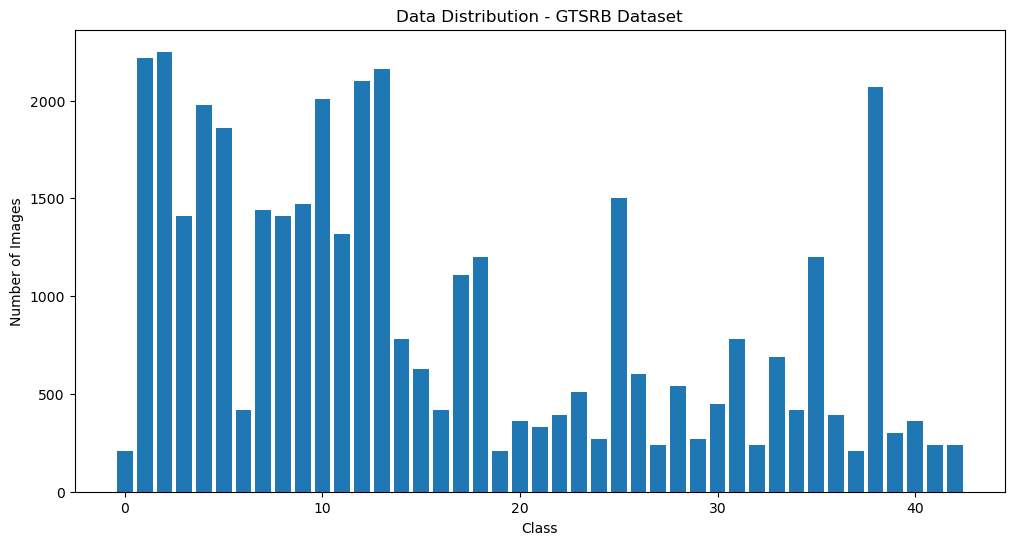

In [4]:
# Count the number of images per class
class_counts = pd.Series(labels).value_counts().sort_index()

# Plot the data distribution
plt.figure(figsize=(12, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Data Distribution - GTSRB Dataset')
plt.show()

In [5]:
# Convert the images and labels to NumPy arrays
images = np.array(images)
labels = np.array(labels)

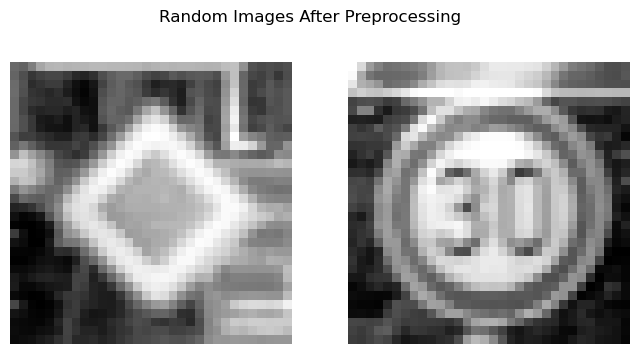

In [9]:
# Display 2 random images after preprocessing 
random_indices = np.random.choice(len(images), 2, replace=False) 

plt.figure(figsize=(8, 4)) 
plt.suptitle('Random Images After Preprocessing') 
for i, idx in enumerate(random_indices): 
    plt.subplot(1, 2, i + 1) 
    plt.imshow(images[idx], cmap='gray') 
    plt.axis('off') 
    
plt.show()

In [10]:
#Reshape the input data for grayscale image
images = images.reshape(-1, 32 , 32 , 1)

In [11]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [12]:
# Data augmentation using ImageDataGenerator
data_augmentor = ImageDataGenerator(
    rotation_range=10, # Randomly rotate images by 10 degrees
    width_shift_range=0.1, # Randomly shift images horizontally by 10% of the width
    height_shift_range=0.1, # Randomly shift images vertically by 10% of the height
    zoom_range=0.2 # Randomly zoom into images by 20%
)

In [13]:
# Fit the ImageDataGenerator on training data
data_augmentor.fit(X_train)

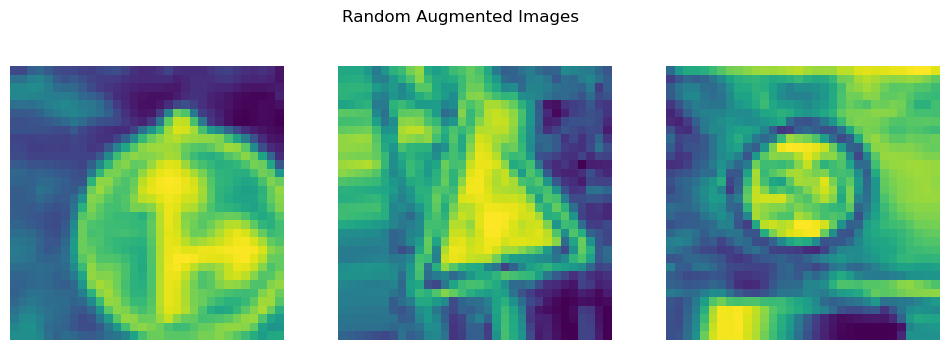

In [14]:
# Generate and visualize random augmented images 
random_augmented_indices = np.random.choice(len(X_train), 3, replace=False) 
random_augmented_images = data_augmentor.flow(X_train, y_train, batch_size=3, shuffle=False)[0][0] 

plt.figure(figsize=(12, 4))
plt.suptitle('Random Augmented Images')

for i, idx in enumerate(random_augmented_indices): 
    plt.subplot(1, 3, i + 1) 
    plt.imshow(random_augmented_images[i].squeeze()) 
    plt.axis('off') 
    
    
plt.show()

In [15]:
# Define the CNN model
model = Sequential()

model.add(Conv2D(60, kernel_size=(5, 5), activation='relu', input_shape=(32, 32, 1)))
model.add(Conv2D(60, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(30, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(30, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))  


In [16]:
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

In [17]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
# Convert labels to one-hot encoded vectors
num_classes = 43
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [20]:
# Train the model

# with epochs = 15  and  batch_size = 64   =>  val_accuracy = 93%

history = model.fit(X_train, y_train, batch_size=500,
                    epochs=30,
                    validation_data=(X_test, y_test) )                                #97.81% val_accuracy


Epoch 1/30
63/63 [==============================] - 185s 3s/step - loss: 3.5445 - accuracy: 0.0527 - val_loss: 3.4869 - val_accuracy: 0.0632
Epoch 2/30
63/63 [==============================] - 181s 3s/step - loss: 3.5006 - accuracy: 0.0512 - val_loss: 3.4793 - val_accuracy: 0.0574
Epoch 3/30
63/63 [==============================] - 178s 3s/step - loss: 3.4985 - accuracy: 0.0555 - val_loss: 3.4793 - val_accuracy: 0.0632
Epoch 4/30
63/63 [==============================] - 179s 3s/step - loss: 3.4934 - accuracy: 0.0552 - val_loss: 3.4754 - val_accuracy: 0.0574
Epoch 5/30
63/63 [==============================] - 179s 3s/step - loss: 3.4881 - accuracy: 0.0587 - val_loss: 3.4603 - val_accuracy: 0.0690
Epoch 6/30
63/63 [==============================] - 180s 3s/step - loss: 3.1330 - accuracy: 0.1680 - val_loss: 1.9576 - val_accuracy: 0.4498
Epoch 7/30
63/63 [==============================] - 208s 3s/step - loss: 1.5911 - accuracy: 0.5198 - val_loss: 0.9500 - val_accuracy: 0.7256
Epoch 8/30
63

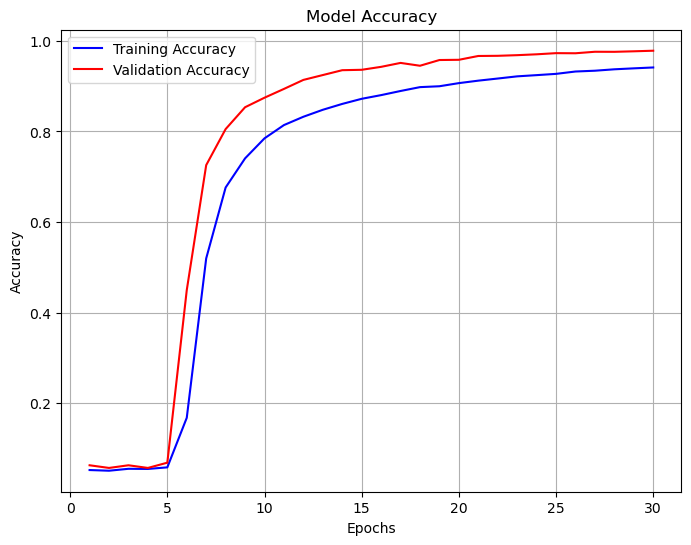

In [21]:
#Visualize the models accuracy

# Access the training and validation accuracy from the history object
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Create a list of epochs
epochs = range(1, len(training_accuracy) + 1)

# Plot the training and validation accuracy over epochs
plt.figure(figsize=(8, 6))
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


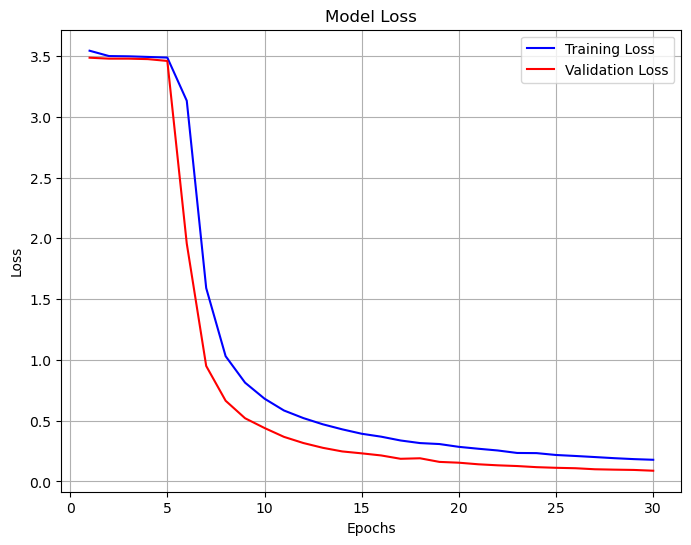

In [22]:
#Visualize the models loss for both the training and validation data.

# Access the training and validation loss from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create a list of epochs (assuming you trained for 30 epochs)
epochs = range(1, len(training_loss) + 1)

# Plot the training and validation loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
# folder of test images
test_folder = 'E:/Downloads/Compressed/final dataset/GTSRB_Final_Test_Images'

In [24]:
# the class names
class_names = [
    'Speed limit (20km/h)',
    'Speed limit (30km/h)',
    'Speed limit (50km/h)',
    'Speed limit (60km/h)',
    'Speed limit (70km/h)',
    'Speed limit (80km/h)',
    'End of speed limit (80km/h)',
    'Speed limit (100km/h)',
    'Speed limit (120km/h)',
    'No passing',
    'No passing for vehicles over 3.5 metric tons',
    'Right-of-way at the next intersection',
    'Priority road',
    'Yield',
    'Stop',
    'No vehicles',
    'Vehicles over 3.5 metric tons prohibited',
    'No entry',
    'General caution',
    'Dangerous curve to the left',
    'Dangerous curve to the right',
    'Double curve',
    'Bumpy road',
    'Slippery road',
    'Road narrows on the right',
    'Road work',
    'Traffic signals',
    'Pedestrians',
    'Children crossing',
    'Bicycles crossing',
    'Beware of ice/snow',
    'Wild animals crossing',
    'End of all speed and passing limits',
    'Turn right ahead',
    'Turn left ahead',
    'Ahead only',
    'Go straight or right',
    'Go straight or left',
    'Keep right',
    'Keep left',
    'Roundabout mandatory',
    'End of no passing',
    'End of no passing by vehicles over 3.5 metric tons'
]

In [145]:
# 4 image for test
num_images_to_test = 4

In [146]:
# Get a list of all image files in the test folder
test_image_files = os.listdir(test_folder)

In [147]:
import random

# Randomly select 4 image files from the list
random_test_image_files = random.sample(test_image_files, num_images_to_test)

In [148]:
# Load and preprocess the selected test images
test_images = []
test_image_names = []  # To store the image file names for later display
for image_file in random_test_image_files:
    image_path = os.path.join(test_folder, image_file)
    image = imageio.imread(image_path)

    # Convert the PPM image to grayscale (assuming it is a 3-channel RGB image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    image = exposure.equalize_hist(image)
    image = image / 255.0
    image = cv2.resize(image, (32, 32))
    test_images.append(image)
    test_image_names.append(image_file)

C:\Users\Morte\AppData\Local\Temp\ipykernel_4092\1039340430.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


In [149]:
# Convert the test images to a NumPy array and reshape for grayscale images
test_images = np.array(test_images)
test_images = test_images.reshape(-1, 32, 32, 1)

In [150]:
# Make predictions using the trained model
predictions = model.predict(test_images)

1/1 [==============================] - 0s 69ms/step


In [151]:
# get the top two predicted class indices and their corresponding probabilities
top_class_indices = np.argsort(predictions, axis=1)[:, -2:]
top_class_probs = np.sort(predictions, axis=1)[:, -2:]

In [152]:
# Map the predicted class numbers to class names for the top tow classes
top_class_names = [[class_names[idx] for idx in indices] for indices in top_class_indices]

In [153]:
# display the names and probabilities of the two most probable classes for each image
for i in range(num_images_to_test):
    print(f"Image: {test_image_names[i]}")
    for j in range(2):
        print(f"Top Class {j + 1}: {top_class_names[i][j]}, Probability: {top_class_probs[i][j]:.2f}")
    print("-" * 40)

Image: 07437.ppm
Top Class 1: Speed limit (30km/h), Probability: 0.47
Top Class 2: Speed limit (50km/h), Probability: 0.52
----------------------------------------
Image: 02578.ppm
Top Class 1: Traffic signals, Probability: 0.00
Top Class 2: Bumpy road, Probability: 1.00
----------------------------------------
Image: 00170.ppm
Top Class 1: No vehicles, Probability: 0.00
Top Class 2: Yield, Probability: 1.00
----------------------------------------
Image: 03111.ppm
Top Class 1: Wild animals crossing, Probability: 0.00
Top Class 2: Road work, Probability: 1.00
----------------------------------------


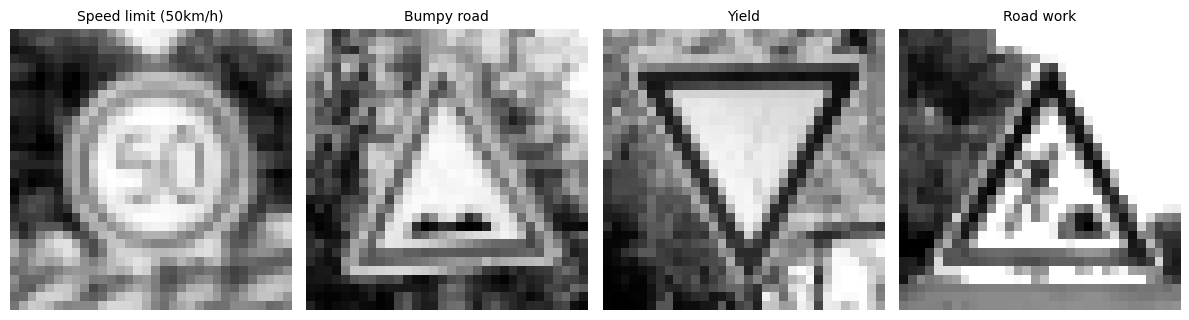

In [154]:
# Visualize the test images along with their predicted Class names
plt.figure(figsize=(12, 6))
for i in range(num_images_to_test):
    plt.subplot(1, num_images_to_test, i + 1)
    plt.imshow(test_images[i].squeeze(), cmap='gray')
    if top_class_probs[i][0] > top_class_probs[i][1]:
        plt.title(top_class_names[i][0] , fontsize=10)
    else:
        plt.title(top_class_names[i][1] , fontsize=10)
    plt.axis('off')
    
plt.tight_layout()
plt.show()